In [38]:
import os
import numpy as np
from scipy import ndimage as ndi
from scipy.stats import poisson
import matplotlib.pyplot as plt
import pandas as pd

from analyfits import misc
from analyfits import manipufits
from analyfits import datafits

In [2]:
# Cargo una lista con los directorios de todas las imágenes.
DIR = "/home/igna/Escritorio/Tesis2021/Archivos/T123K"
#DIR_win = "D:\ignag\Igna\Facultad\Tesis2021\Archivos\T123K"
os.chdir(DIR)
fits_imgs_list = misc.fits_finder(DIR)

# Prueba de Concepto

### Pasos
- 1) Tomar una imagen en unidades de electrones ```img_original```
- 2) Separarla en dos imágenes, una con eventos de 1 e y otra con los restantes: ```img_clusters```
- 3) Tomo la imagen con eventos de 2 o más electrones y la dilato 2 veces para crear la máscara ```mask```
- 4) Uso la máscara para, en la imagen original (```img_original```), hacer 0 los valores que corresponden (donde la máscara es ```True```)
- 5) Calculo la relación entre cantidad de píxeles con eventos de 1 electrón vs píxeles vacíos.
    - 5)a) ¿Píxeles no ocupados por la máscara? <- esta voy a hacer yo porque tiene más sentido.
    - 5)b) ¿Píxeles no ocupados totales?

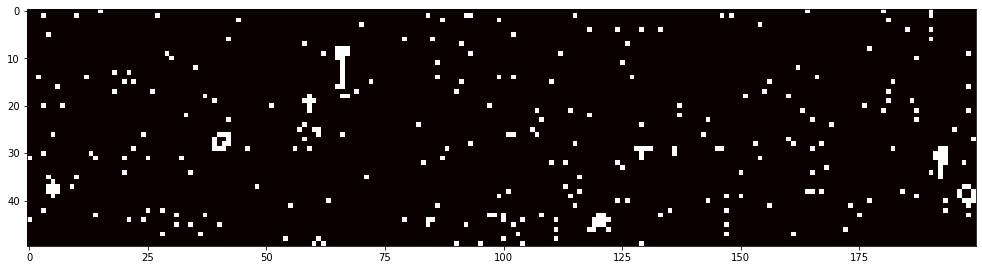

In [3]:
# agarro una imagen random
import random
img_dir = random.choice(fits_imgs_list)

# 1)
# Abro la imagen orignal (completa en electrones)
img_original = manipufits.ADU2e(img_dir)[0]

# 2)
# La transformo a matriz numpy y la separo en 2
img_clusters = manipufits.single_fits2double_fits(img_dir)[1]

# Imagen original
plt.figure(figsize=(17,9))
plt.imshow(img_clusters[0:50, 100:300], cmap="hot", vmin=0, vmax=2)

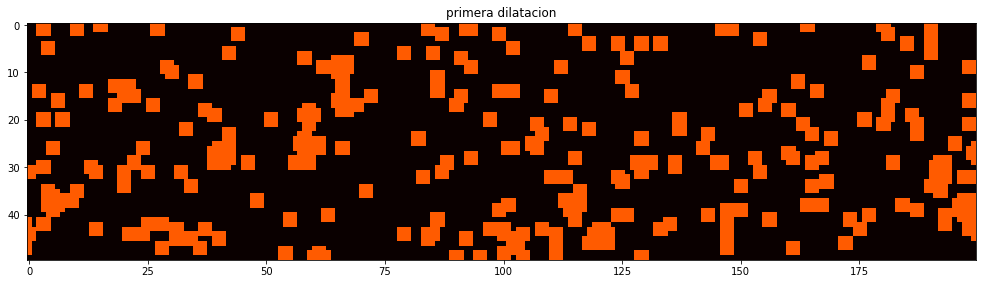

In [4]:
struct = [[1,1,1],
          [1,1,1],
          [1,1,1]]

# 3)
# Imagen dilatada 1 vez
img_dilat = ndi.morphology.binary_dilation(img_clusters, structure=struct)
plt.figure(figsize=(17,9))
plt.title("primera dilatacion")
plt.imshow(img_dilat[0:50, 100:300], cmap="hot", vmin=0, vmax=2)

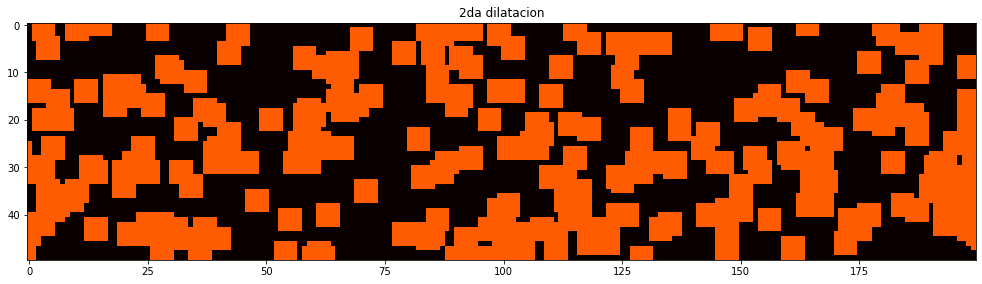

In [5]:
# 3)
# Imagen dilatada 2 veces: Máscara
mask = ndi.morphology.binary_dilation(img_dilat, structure=struct)
plt.figure(figsize=(17,9))
plt.title("2da dilatacion")
plt.imshow(mask[0:50, 100:300], cmap="hot", vmin=0, vmax=2)

### Ahora uso la máscara para eliminar de la imagen original todos los eventos de 2 o más electrones, y quedarme solo con los de 1 electrón alejados

In [6]:
# 4)
clean_image = np.where(mask==True, 0, img_original)

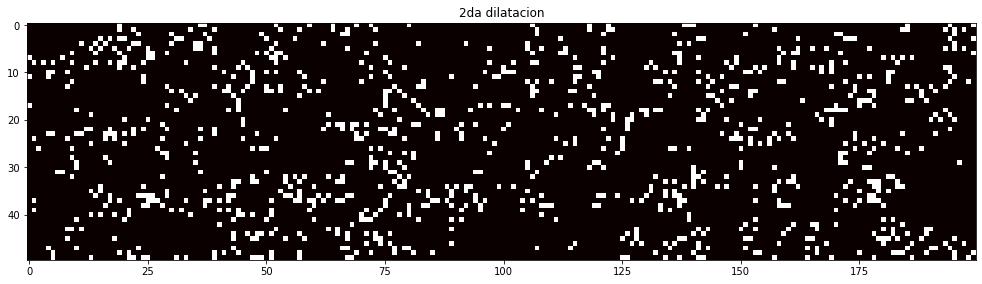

In [7]:
plt.figure(figsize=(17,9))
plt.title("2da dilatacion")
plt.imshow(clean_image[0:50, 100:300]*10, cmap="hot", vmin=0, vmax=2)

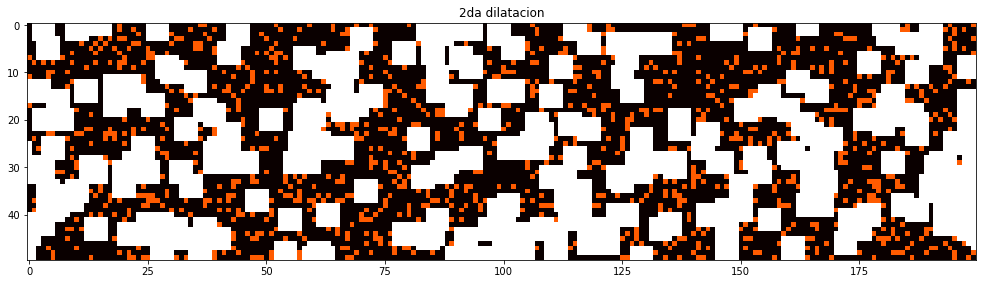

In [8]:
plt.figure(figsize=(17,9))
plt.title("2da dilatacion")
plt.imshow((mask*20 + clean_image)[0:50, 100:300]*10, cmap="hot", vmin=0, vmax=20)

In [9]:
ones = clean_image[clean_image==1].size
zeros = clean_image[clean_image==0].size - mask[mask==True].size
rate = ones/zeros
rate

0.18737640079103493

Para todas las imágenes:

In [10]:
zeros = 0
ones = 0
for i, img in enumerate(fits_imgs_list):
    # Original
    img_original = manipufits.ADU2e(img)[0][:, 8:451]
    # 2 o más eventos
    img_clusters = manipufits.single_fits2double_fits(img)[1][:, 8:451]
    # Estructura
    struct = [[1,1,1],
              [1,1,1],
              [1,1,1]]
    
    # Máscara (dilato 2 veces)
    mask = ndi.morphology.binary_dilation(img_clusters, structure=struct, iterations=2)
    # Resta: Donde está la mascara, elimino eventos en la imagen original
    img_clean = np.where(mask==True, 0, img_original)
    # Acumulo
    zeros += img_clean[img_clean==0].size - mask[mask==True].size
    ones += img_clean[img_clean==1].size
    porcentaje = (i+1)*100/len(fits_imgs_list)
    print(f"\rCompletado {porcentaje:.2f}%",end= "")

Completado 100.00%

In [11]:
mu_bkg = ones/zeros
mu_g = 0.2245 - mu_bkg
error_bkg = np.sqrt((1/np.sqrt(ones))**2 + (1/np.sqrt(zeros))**2)*(ones/zeros)
print(f"Entonces el µ de background es: µ_bkg = {mu_bkg:.5f} +/- {error_bkg:.5f}")

Entonces el µ de background es: µ_bkg = 0.21505 +/- 0.00017


### El $\mu_{bkg} = 0.21505 \pm 0.00017$ y tiene sentido que ande cerca del $\mu_{T} = 0.2245 \pm 0.0001$, porque la mayoría de los eventos de $1\,e^{-}$ deben venir de corrientes oscuras.

La pregunta ahora es:
- Si $\mu_{T} = 0.02245 \pm 0.0001$
- y $\mu_{bkg} = 0.21505 \pm 0.00017$
- ¿Entonces $\mu_{g} = \mu_{T} - \mu_{bkg}$?

En ese caso entonces

\begin{equation}
    \mu_{g} = 0.0094 \pm 0.0001
\end{equation}

## Análisis de bordes

In [12]:
real_p = poisson.pmf(mu=mu_g, k=1)
bkg_p = poisson.pmf(mu=mu_bkg, k=1)
real_border_charge = 0
bkg_border_charge = 0
measured_border_charge = 0
for i, image in enumerate(fits_imgs_list):
    charge, pixels, n_clusters = datafits.border_events(image, low_th=2)
    real_border_charge += pixels*real_p
    bkg_border_charge += pixels*bkg_p
    measured_border_charge += charge
    percentage = (i+1)*100/len(fits_imgs_list)
    print(f"\rCompletado {percentage:.2f}%",end= "")

Completado 100.00%

In [13]:
print(f"Carga real esperada: {real_border_charge:.2f}")
print(f"Carga espuria esperada: {bkg_border_charge:.2f}")
print(f"Carga medida: {measured_border_charge:.2f} ")

Carga real esperada: 314.69
Carga espuria esperada: 5832.27
Carga medida: 6538.00 


## Análisis de clusters

In [15]:
# datos de las imagenes originales
lista_dics, lista_img_idx = datafits.image2cluster_info(fits_imgs_list,
                                                        img="o",
                                                        upp_th=None)

100.00%

NameError: name 'lista_dics_o' is not defined

In [17]:
# Armo el dataframe
df = datafits.df_gen(lista_dics, lista_img_idx)

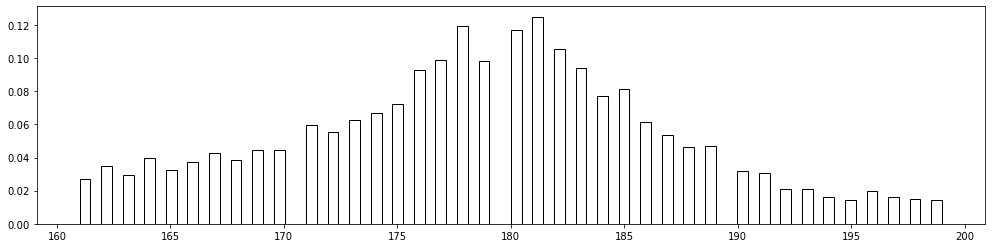

In [62]:
fluor = df[(df["energia"]>160) &  (df["energia"]<200)].copy()
plt.figure(figsize=(17,4))
plt.hist(fluor["energia"], bins=80, fill=False, density=True);

Voy a tomar los eventos entre 160 y 220 y, sabiendo la cantidad de eventos espurios en la superficie del clúster van como $N\mu_{bkg}$ (donde $N$ es la cantidad de píxeles del clúster), calculo cuántos eventos tengo que sacar para tener el número real de estos

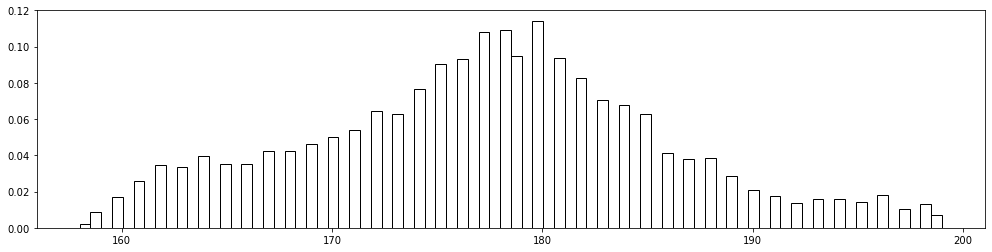

In [63]:
fluor["espurios"] = round(fluor["area"]*mu_bkg)
fluor["energia_corregida"] = fluor["energia"] - fluor["espurios"]
plt.figure(figsize=(17,4))
plt.hist(fluor["energia_corregida"], bins=80, fill=False, density=True);

In [67]:
mean_energia = fluor["energia_corregida"].mean()
std_energia = fluor["energia_corregida"].std()
fano = std_energia**2/mean_energia
fano

0.39847840276705865

In [68]:
mean_energia = fluor["energia"].mean()
std_energia = fluor["energia"].std()
fano = std_energia**2/mean_energia
fano

0.39292322496471466